In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from GPyOpt.methods import BayesianOptimization
import json
EXPERT_PATH = ['..\\research\data_expert_demo.h5', "..\\research\data_expert_demo_17_1.h5","..\\research\data_expert_demo_3.h5","..\\research\data_expert_demo_4.h5"]

In [17]:


combined_df = pd.DataFrame()  # Create an empty DataFrame to store the combined data

for path in EXPERT_PATH:
    try:
        data = pd.read_hdf(path)
        combined_df = pd.concat([combined_df, data])  # Concatenate the current file's data to the combined DataFrame
    except FileNotFoundError:
        print('File {} not found'.format(path))


expert_data =combined_df
type(expert_data)

pandas.core.frame.DataFrame

In [18]:
expert_data.columns

Index(['midi_filename', 'username', 'practice_mode', 'bpm',
       'error_before_left_timing', 'error_before_right_timing',
       'error_before_left_pitch', 'error_before_right_pitch',
       'error_after_left_timing', 'error_after_right_timing',
       'error_after_left_pitch', 'error_after_right_pitch'],
      dtype='object')

In [19]:
import enum
import random
import numpy as np

import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization


class PracticeMode(enum.Enum):
    """
    All possible practice modes
    """
    IMP_PITCH = 0
    IMP_TIMING = 1
    LEFT = 2
    RIGHT = 3


# interval of possible bpm_values
BPM_BOUNDS = [50, 200]
class GaussianProcess:
    def __init__(self, bpm_norm_fac=100):
        self.data_X = None
        self.data_X_old_shape = None

        self.data_Y = None

        self.bpm_norm_fac = bpm_norm_fac

        self.domain = [
            {'name': 'practice_mode', 'type': 'categorical', 'domain': (0, 1, 2, 3)},
            {'name': 'bpm', 'type': 'continuous', 'domain':
                (self._norm_bpm(BPM_BOUNDS[0]), self._norm_bpm(BPM_BOUNDS[1]))},
            {'name': 'error_pitch_left', 'type': 'continuous', 'domain': (0, 1)},
            {'name': 'error_pitch_right', 'type': 'continuous', 'domain': (0, 1)},
            {'name': 'error_timing_left', 'type': 'continuous', 'domain': (0, 1)},
            {'name': 'error_timing_right', 'type': 'continuous', 'domain': (0, 1)}
        ]

        self.space = GPyOpt.core.task.space.Design_space(self.domain)

    def _norm_bpm(self, v: float) -> float:
        return v / self.bpm_norm_fac

    def _params2domain(self, error, bpm: int, practice_mode: PracticeMode):
        domain_x = [
            practice_mode.value,
            self._norm_bpm(bpm),
            error['pitch_left'],
            error['pitch_right'],
            error['timing_left'],
            error['timing_right']
        ]

        return np.array([domain_x])

    def _domain2space(self, domain_x):
        # Converts the domain variables into the GPs input space
        # does one-hot encoding
        space_rep = self.space.unzip_inputs(domain_x)
        return space_rep

    def _get_bayes_opt(self) -> BayesianOptimization:
        return self.bayes_opt

    def update_model(self):
        """
        If the Gaussian Process' training data has changed, "trains" the GP on the complete data set.
        """
        if self.data_X is None or self.data_X.shape == self.data_X_old_shape:
            return

        self.data_X_old_shape = self.data_X.shape

        kernel = GPy.kern.RBF(input_dim=self.space.model_dimensionality,
                              variance=0.01,
                              lengthscale=1)

        self.bayes_opt = GPyOpt.methods.BayesianOptimization(
            f=None, domain=self.domain, X=self.data_X, Y=self.data_Y,
            maximize=True, normalize_Y=False,
            kernel=kernel,
        )

        self.bayes_opt.model.max_iters = 0
        self.bayes_opt._update_model()

        self.bayes_opt.model.max_iters = 1000
        self.bayes_opt._update_model()

    def get_estimate(self, error, bpm, practice_mode: PracticeMode) -> float:
        """
        Estimates the utility value for a given practice mode
        @param error: error values
        @param bpm: bpm of the music piece
        @param practice_mode: the practice mode for which the utility value should be estimated
        @return: gaussian process' estimate of the utility value
        """
        if not hasattr(self, "bayes_opt"):
            # if there is no model yet, e.g. in the first iteration return random utility
            return random.random()

        bayes_opt = self._get_bayes_opt()

        x = self._params2domain(error, bpm, practice_mode)
        x = self._domain2space(x)

        mean, var = bayes_opt.model.predict(x)

        return mean[0]

    def get_best_practice_mode(self, error, bpm, epsilon=0):
        """
        computes the gaussian process' estimate of the best practice mode
        currently utilizes epsilon-greedy exploration
        @param error: error values
        @param bpm: bpm of the music piece
        @param (optional) epsilon: the probability of making a random decision. set to 0 for no exploration.
        @return: chosen for given input parameters PracticeMode
        """
        left = False
        right = True
        if left and right:
            all_practice_modes = list(PracticeMode)
        else:
            all_practice_modes = [PracticeMode.IMP_PITCH, PracticeMode.IMP_TIMING]
        # epsilon-greedy
        if random.random() > epsilon:
            max_i = np.argmax([self.get_estimate(error, bpm, pm)
                               for pm in all_practice_modes])
            return all_practice_modes[max_i]
        else:
            return np.random.choice(all_practice_modes)

    def add_data_point(self, error, bpm: int, practice_mode: PracticeMode,
                       utility_measurement: float):
        """
        Adds a new datapoint to the dataset of the gaussian process.
        Does not update the Gaussian Process for the new training data (see: update_model)
        @param error: error values
        @param bpm: bpm of the music piece
        @param practice_mode: practice mode in which the performer practiced
        @param utility_measurement: observed utility value for the given parameters
        """

        new_x = self._params2domain(error, bpm, practice_mode)
        new_y = [utility_measurement]

        if self.data_X is None:
            self.data_X = new_x
            self.data_Y = np.array([new_y])
        else:
            self.data_X = np.vstack((self.data_X, new_x[0]))
            self.data_Y = np.vstack((self.data_Y, new_y[0]))
            
    def update_model_with_kernel(self, kernel):
    #it seems possible to enter the kernel to the functionality...

        ## only calculate new model if data changed
        if self.data_X is None or self.data_X.shape == self.data_X_old_shape:
            return
        
        
        self.data_X_old_shape = self.data_X.shape
        
        
        
        self.bayes_opt = GPyOpt.methods.BayesianOptimization(
            f = None, domain = self.domain, X = self.data_X, Y = self.data_Y,
            maximize=True,
            kernel=kernel,
        )
        
        self.bayes_opt.model.max_iters = 0
        self.bayes_opt.update_model_with_kernel(kernel) 
        
        self.bayes_opt.model.model.kern.variance.constrain_bounded(0.2,1,
                                                                   warning=False)
        self.bayes_opt.model.model.kern.lengthscale.constrain_bounded(1, 2,
                                                                   warning=False)
        
        self.bayes_opt.model.max_iters = 1000
        self.bayes_opt.update_model_with_kernel(kernel) 
        
   
    
def compare_to_best_policy(policy_argmax, best_argmax, best_error_diff=1):
        num_diff_cases = np.sum(np.abs(policy_argmax-best_argmax))
    
        abs_diff = num_diff_cases / policy_argmax.shape[0]

    
        return abs_diff

In [20]:
def error_diff_to_utility_for_opt(error_pre_pitch, error_post_pitch, error_pre_timing, error_post_timing, a,MEAN_UTILITY):
    diff_timing = error_post_timing - error_pre_timing
    diff_pitch  = error_post_pitch  - error_pre_pitch
    return - (diff_timing*a + diff_pitch*(1-a)) - MEAN_UTILITY

In [21]:
def calc_ground_truth_utility(recorded_points,a,mean_utility):
    #calc utility for all expert data
    recorded_points["utility"] = recorded_points.apply(lambda row: error_diff_to_utility_for_opt(row["error_before_right_pitch"],
                                                                                row["error_after_right_pitch"],
                                                                                row["error_before_right_timing"],
                                                                                row["error_after_right_timing"],a, mean_utility), axis=1)
    return recorded_points  

In [22]:
def policy_diff_for_single_gp(gauss_model, recorded_points,a,mean_utility):
    #calculate the policy diff for a single gp, given the recorded points and the expert decision
    policy_diff = []
    practice_mode_map = {'IMP_PITCH': PracticeMode.IMP_PITCH, 'IMP_TIMING': PracticeMode.IMP_TIMING}
    #for all recorded data points
    recorded_points = calc_ground_truth_utility(recorded_points, a, mean_utility)
    for i, point in recorded_points.iterrows():

        #prepare the data in the right format for adding to the gp

        point_data = point.drop("utility")
        expert_opt_policy = point["utility"]
        bpm=point["bpm"]
        given_practice_mode = point["practice_mode"]
        my_practice_mode = practice_mode_map[given_practice_mode]
       
        errors = {
    'pitch_left': point_data['error_before_left_pitch'],
    'pitch_right': point_data['error_before_right_pitch'],
    'timing_left': point_data['error_before_left_timing'],
    'timing_right': point_data['error_before_right_timing']}

        #add the data point to the gp
 
        gauss_model.add_data_point(errors ,bpm, my_practice_mode, expert_opt_policy)
        gauss_model.update_model()
        
        #calculate the policy diff for the current gp, for the current point
        
        curr_diff = compare_to_best_policy(gauss_model.get_estimate(errors, bpm, my_practice_mode),expert_opt_policy)
        #print(curr_diff)
        policy_diff.append(curr_diff)
    #print(mean(policy_diff))
    return policy_diff

In [23]:
def update_model_with_kernel(self, kernel):
    #a version for updating the model with a given kernel

        ## only calculate new model if data changed
        if self.data_X is None or self.data_X.shape == self.data_X_old_shape:
            return
        
        
        self.data_X_old_shape = self.data_X.shape
        
        
        
        self.bayes_opt = GPyOpt.methods.BayesianOptimization(
            f = None, domain = self.domain, X = self.data_X, Y = self.data_Y,
            maximize=True,
            kernel=kernel,
        )
        
        self.bayes_opt.model.max_iters = 0
        self.bayes_opt.update_model_with_kernel(kernel) 
        
        self.bayes_opt.model.model.kern.variance.constrain_bounded(0.2,1,
                                                                   warning=False)
        self.bayes_opt.model.model.kern.lengthscale.constrain_bounded(1, 2,
                                                                   warning=False)
        
        self.bayes_opt.model.max_iters = 1000
        self.bayes_opt.update_model_with_kernel(kernel) 
        pass

In [24]:
def optimal_gp(gauss_models, policy_diff):
    #we choose the gp with the lowest mean policy diff
    best_model_index = np.argmin([np.mean(pd) for pd in policy_diff])
    best_model = gauss_models[best_model_index]
    return best_model



In [25]:
from statistics import mean 
def objective_function(x, kernel_type):
    #objective function for the optimization of the hyperparameters, getting the mean policy diff for the current hyperparameters
    if x.ndim > 1:
        x = x.flatten()
    # x is a list of hyperparameters
    if kernel_type == 'RatQuad':
        variance, lengthscale, alpha, a, mean_utility = x
    else:
        variance, lengthscale, a, mean_utility = x
    
    # Initialize a GP model with the given hyperparameters and kernel type
    gp = GaussianProcess()
    if kernel_type == 'Matern52':
        kernel = GPy.kern.Matern52(input_dim=gp.space.model_dimensionality, 
                                   variance=variance, 
                                   lengthscale=lengthscale)
    elif kernel_type == 'linear':
        kernel = GPy.kern.Linear(input_dim=gp.space.model_dimensionality,
                                 variances=variance)
    elif kernel_type == 'RatQuad':
        kernel = GPy.kern.RatQuad(input_dim=gp.space.model_dimensionality,
                                    variance=variance,
                                    lengthscale=lengthscale,
                                    power=alpha)
    else:
        raise ValueError("Invalid kernel type")

    gp.update_model_with_kernel(kernel)

    # Calculate the utility using the expert data and the GP model
    recorded_points = expert_data[[ 'error_before_left_timing', 'error_before_right_timing',
       'error_before_left_pitch', 'error_before_right_pitch',
       'error_after_left_timing', 'error_after_right_timing',
       'error_after_left_pitch', 'error_after_right_pitch', "practice_mode", "bpm"]]
    policy_diff = policy_diff_for_single_gp(gp, recorded_points,a,mean_utility)
    return  mean(policy_diff)


    


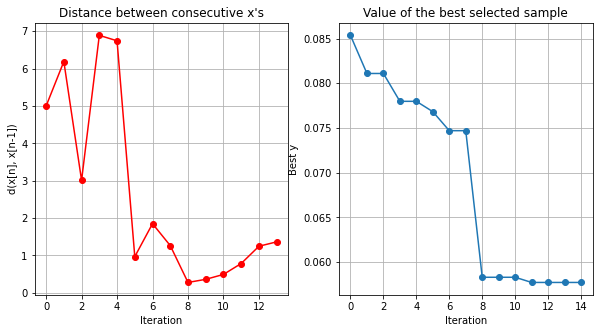

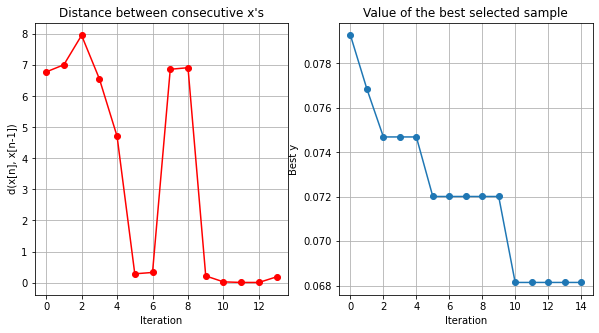

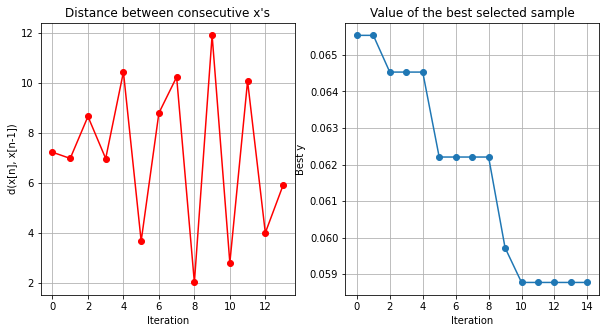

In [26]:

#initialize the hyper parameters bound for different kernels
kernel_types = ['Matern52', 'linear', 'RatQuad']
#kernel_types = ['Matern52']
rqk_bounds = [{'name': 'variance', 'type': 'continuous', 'domain': (0.01, 10)},
          {'name': 'lengthscale', 'type': 'continuous', 'domain': (0.1, 10)},
          {'name': 'alpha', 'type': 'continuous', 'domain': (0.1, 10)},
          {'name': 'a', 'type': 'continuous', 'domain': (0.3,0.7)},
          {'name': 'mean_utility', 'type': 'continuous', 'domain': (0, 1)}]

bounds = [{'name': 'variance', 'type': 'continuous', 'domain': (0.01, 10)},
          {'name': 'lengthscale', 'type': 'continuous', 'domain': (0.1, 10)},
          {'name': 'a', 'type': 'continuous', 'domain': (0.3, 0.7)},
          {'name': 'mean_utility', 'type': 'continuous', 'domain': (0.01, 1)}]

#bounds = [{'name': 'variance', 'type': 'continuous', 'domain': (0.5, 0.7)},
          #{'name': 'lengthscale', 'type': 'continuous', 'domain': (0.5, 0.7)},
          #{'name': 'a', 'type': 'continuous', 'domain': (0.5, 0.7)},
        #  {'name': 'mean_utility', 'type': 'continuous', 'domain': (0.5, 0.7)}]

best_gp_dict ={}
best_gp_dict_policy = {}
#for each kernel
for kernel_type in kernel_types:
#do baysian optimization
    
    if kernel_type == 'RatQuad':
        bounds_ = rqk_bounds
    else:
        bounds_ = bounds
    obj_func = lambda x: objective_function(x, kernel_type)
    bo = BayesianOptimization(f=obj_func,
                              domain=bounds_,
                              acquisition_type='EI',
                              acquisition_jitter=0.05,
                              num_cores=1)
    # Run the optimization
    bo.run_optimization(max_iter=10)
    # Get the best set of hyperparameters
    bo.plot_convergence()

    best_hyperparameters = bo.x_opt
    best_mean_policy_diff = bo.fx_opt
    best_gp_dict[kernel_type] = best_hyperparameters
    best_gp_dict_policy[kernel_type] = best_mean_policy_diff

In [27]:
best_gp_dict

{'Matern52': array([5.08942964, 2.8095464 , 0.7       , 0.04113724]),
 'linear': array([7.92769988, 2.0447717 , 0.5709087 , 0.62205863]),
 'RatQuad': array([0.01, 0.1 , 0.1 , 0.7 , 0.  ])}

In [28]:
best_gp_dict_policy

{'Matern52': 0.05771076143338213,
 'linear': 0.06814846798791784,
 'RatQuad': 0.05877368670882635}

In [38]:
best_kernel_type = min(best_gp_dict_policy, key=best_gp_dict_policy.get) 
best_param = best_gp_dict[best_kernel_type]
#get a dict of the parameters for the best kernel with its name as the key, and also the best mean policy diff and the kernel type
best_param_dict = dict(zip([b['name'] for b in bounds], best_param))
best_kernel = {"name": best_kernel_type, "best parameters": best_param_dict, "policy-diff": best_gp_dict_policy[best_kernel_type]}
best_kernel

{'name': 'Matern52',
 'best parameters': {'variance': 5.089429639257508,
  'lengthscale': 2.8095463984389255,
  'a': 0.7,
  'mean_utility': 0.041137238696461985},
 'policy-diff': 0.05771076143338213}

In [39]:
file_path = 'best_kernel.json'

# Open the file in write mode and save the dictionary as JSON
with open(file_path, 'w') as json_file:
    json.dump(best_kernel, json_file)

ADD OPTIMIZATION FOR UTILITY CALCULATION PARAMETERS
am not calculating left hand error(there is none in the expert data)